# Assignment-3

## TEAM-30 

### Team Members: Maria Nivetha Antony Pushparaj(marianiv), Gayathri Sruthi Gannamaneni(ggannama) 

### Importing Libraries

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from torch.distributions import Categorical

### Part - 1 CartPole 

In [686]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

In [687]:
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [689]:
class A2CAgent:
    def __init__(self,state_size,action_size):
        self.actor = Actor(state_size,action_size)
        self.critic = Critic(state_size)
        lr_actor = 0.001
        lr_critic = 0.001
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = 0.99

  
    def compute_action(self,state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs= self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action,dist
    
    def learn(self,state,action,reward,next_state,done,dist):
        state = torch.FloatTensor(state)
        reward = torch.FloatTensor([reward])
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor([done])
        
        log_probs = dist.log_prob(action)
        next_state_value = self.critic(next_state)
        current_state_value = self.critic(state)

        TD_target = reward + (1 - done) * self.gamma * next_state_value
        TD_target = torch.FloatTensor(TD_target)
        current_state_value = torch.FloatTensor(current_state_value)
        advantages = TD_target - current_state_value

        # Actor loss
        self.actor_optimizer.zero_grad()
        actor_loss = -torch.mean(log_probs * advantages.detach())
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic loss
        self.critic_optimizer.zero_grad()
        critic_loss = advantages.pow(2).mean()
        # critic_loss = F.smooth_l1_loss(current_state_value,TD_target)
        critic_loss.backward()
        self.critic_optimizer.step()

    def save_weights(self):
        torch.save(self.actor.state_dict(), 'cartpole_policy_parameters.pth')
    

In [709]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = A2CAgent(state_size,action_size)
num_episodes = 2000
cumulative_rewards = []
for episode in range(num_episodes):
    state,_ = env.reset()
    done = False
    truncated = False
    total_rewards = 0
    while not done or not truncated:
        action, dist = agent.compute_action(state)
        next_state, reward, done, truncated, info = env.step(action.item())
        agent.learn(state, action, reward, next_state, done, dist)
        state = next_state
        total_rewards += reward
        if done or truncated:
            break
    cumulative_rewards.append(total_rewards)
    if np.mean(cumulative_rewards[-15:])>=470:
        agent.save_weights()
        break

    print("Episode:", episode + 1, "Total Reward:", total_rewards)

Episode: 1 Total Reward: 23.0
Episode: 2 Total Reward: 15.0
Episode: 3 Total Reward: 14.0
Episode: 4 Total Reward: 25.0
Episode: 5 Total Reward: 14.0
Episode: 6 Total Reward: 16.0
Episode: 7 Total Reward: 20.0
Episode: 8 Total Reward: 19.0
Episode: 9 Total Reward: 27.0
Episode: 10 Total Reward: 24.0
Episode: 11 Total Reward: 11.0
Episode: 12 Total Reward: 17.0
Episode: 13 Total Reward: 14.0
Episode: 14 Total Reward: 20.0
Episode: 15 Total Reward: 20.0
Episode: 16 Total Reward: 62.0
Episode: 17 Total Reward: 23.0
Episode: 18 Total Reward: 31.0
Episode: 19 Total Reward: 64.0
Episode: 20 Total Reward: 15.0
Episode: 21 Total Reward: 42.0
Episode: 22 Total Reward: 24.0
Episode: 23 Total Reward: 36.0
Episode: 24 Total Reward: 30.0
Episode: 25 Total Reward: 36.0
Episode: 26 Total Reward: 51.0
Episode: 27 Total Reward: 25.0
Episode: 28 Total Reward: 27.0
Episode: 29 Total Reward: 18.0
Episode: 30 Total Reward: 22.0
Episode: 31 Total Reward: 24.0
Episode: 32 Total Reward: 32.0
Episode: 33 Total

Text(0.5, 1.0, 'CartPole during Training')

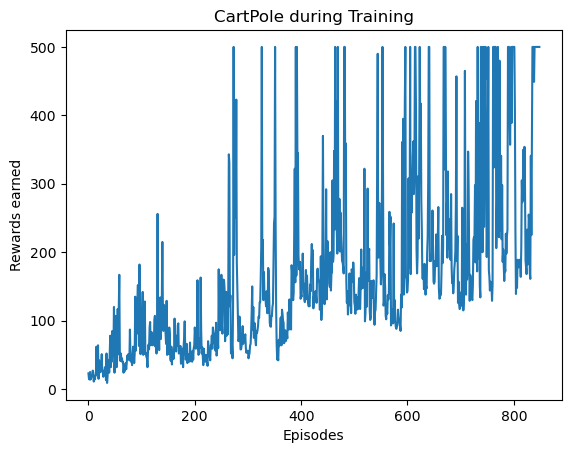

In [710]:
plt.plot(cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('CartPole during Training')

In [711]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = A2CAgent(state_size,action_size)
agent.actor.load_state_dict(torch.load('cartpole_policy_parameters.pth'))
total_rewards_test = []

for i in range(10):
    state,_ = env.reset()
    total_rewards = 0
    done = False
    truncated = False
    for j in range(500):
        action,_ = agent.compute_action(state)
        state, reward, terminated,truncated, info  = env.step(action.item())
        if terminated:
            break
        total_rewards = total_rewards + reward

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'Cartpole environment during testing')

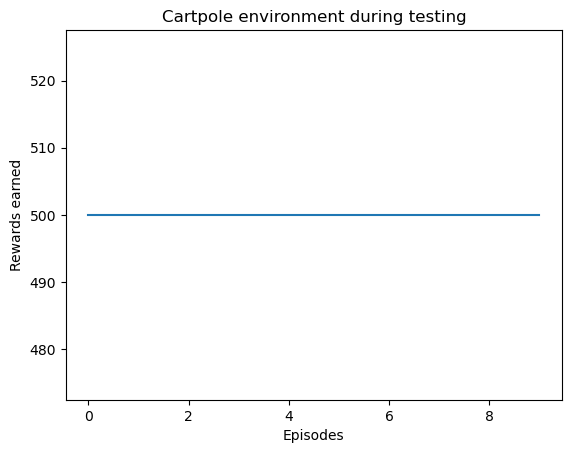

In [712]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Cartpole environment during testing')

# Part - II

### Grid World Environment

In [92]:
class Actor(nn.Module):
    def __init__(self, input_size,output_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

In [93]:
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [94]:
class GridEnv_Deterministic(gym.Env):

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None):


        self.observation_space = spaces.Discrete(25)

        # To demonstrate 4 actions : "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.state = np.zeros((5,5))
        self.state[tuple(self.agent_pos)] = 2
        self.state[tuple(self.goal_pos)] = 1.5
        self.environment_width = 6
        self.environment_height = 6
        self.r1_flag = 0
        self.r2_flag = 0
        self.r3_flag = 0
        self.r4_flag = 0
        self.r5_flag = 0
        self.r6_flag = 0
        self.r7_flag = 0
        self.r8_flag = 0
        self.r9_flag = 0

        # self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)

        self.ghost = np.asarray([4, 0])
        self.zombie = np.asarray([4, 2])
        self.grim = np.asarray([1, 3])
        self.torchlight = np.asarray([[2, 2], [2, 0]])
        self.pill = np.asarray([3, 3])
        self.torch = np.asarray([0,2])
        self.cloak = np.asarray([2, 4])



    # Reset function
    def reset(self, **kwargs):

      self.state = np.zeros((5,5))
      self.agent_pos = [0, 0]
      self.goal_pos = [4, 4]
      self.r1_flag = 0
      self.r2_flag = 0
      self.r3_flag = 0
      self.r4_flag = 0
      self.r5_flag = 0
      self.r6_flag = 0
      self.r7_flag = 0
      self.r8_flag = 0
      self.r9_flag = 0

      return self.agent_pos

    def step(self, action):

      curr_pos = ''

      if action == 0: #right
        curr_pos = 'right'
        self.agent_pos[0] += 1
      if action == 1: #left
        curr_pos = 'left'
        self.agent_pos[0] -= 1
      if action == 2: #up
        curr_pos = 'up'
        self.agent_pos[1] += 1
      if action == 3: #down
        curr_pos = 'down'
        self.agent_pos[1] -= 1


      if self.agent_pos[1]<4 or self.agent_pos[1]>0 or self.agent_pos[0]<4 or self.agent_pos[0]>0:
        if self.agent_pos[0]<0:
          curr_pos = 'right'
          self.agent_pos[0] += 2
        if self.agent_pos[1]<0:
            curr_pos = 'up'
            self.agent_pos[1] += 2
        if self.agent_pos[0]>4:
          curr_pos = 'left'
          self.agent_pos[0] -=2
        if self.agent_pos[1]>4:
          curr_pos = 'down'
          self.agent_pos[1] -=2


      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 0.6
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()

      #Rewards

      reward = 0

      if np.array_equal(self.agent_pos,[0,2]) and self.r1_flag==0:
        reward = 3
        self.r1_flag = 1
      elif np.array_equal(self.agent_pos,[1,1]) and self.r2_flag==0:
        reward = 2
        self.r2_flag = 1
      elif np.array_equal(self.agent_pos,[2,0]) and self.r3_flag==0:
        reward = -1
        self.r3_flag = 1
      elif np.array_equal(self.agent_pos,[1,3]) and self.r4_flag==0:
        reward = -3
        self.r4_flag=1
      elif np.array_equal(self.agent_pos,[2,4]) and self.r6_flag==0:
        reward = 4
        self.r6_flag=1
      elif np.array_equal(self.agent_pos,[3,2]) and self.r7_flag==0:
        reward = 1
        self.r7_flag=1
      elif np.array_equal(self.agent_pos,[4,0]) and self.r8_flag==0:
        reward = 1
        self.r8_flag=1
      elif np.array_equal(self.agent_pos,[4,3]) and self.r9_flag==0:
        reward = -2
        self.r9_flag=1
      elif np.array_equal(self.agent_pos,self.goal_pos):
        reward = 10

      terminated = True if np.array_equal(self.agent_pos, self.goal_pos) else False
      truncated = True if np.all((np.asarray(self.agent_pos) >=0 ) & (np.asarray(self.agent_pos) <= 4)) else False

      info = {}

      if curr_pos =='':
        curr_pos = 'Same state due to truncation of going beyond grid'

      return self.agent_pos, reward, terminated, truncated, info , curr_pos

    # Render function: Visualizes the environment
    def grid_render(self, plot=False):

        fig, ax = plt.subplots(figsize=(7,7))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
        def plot_image(plot_pos):

        # Initially setting every object to not be plotted.
            plot_agent,plot_goal,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak = \
                False, False, False, False, False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.ghost, plot_pos):
                plot_ghost = True
            if np.array_equal(self.zombie, plot_pos):
                plot_zombie = True
            if np.array_equal(self.grim, plot_pos):
                plot_grim = True
            if np.array_equal(self.pill, plot_pos):
                plot_pill= True
            if any(np.array_equal(self.torchlight[i], plot_pos) for i in range(len(self.torchlight))):
                plot_torchlight = True
            if (np.array_equal(self.torch, plot_pos)):
               plot_torch = True
            if np.array_equal(self.cloak, plot_pos):
                plot_cloak = True
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if np.array_equal(self.goal_pos, plot_pos):
                plot_goal = True

            # Plot for Agent.
            if plot_agent and \
                        all(not item for item in
                            [plot_goal,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                    agent = AnnotationBbox(OffsetImage(plt.imread('./RL images/Start.png'), zoom=0.28),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(agent)

            # Plot for ghost
            elif plot_ghost and \
                    all(not item for item in
                        [plot_goal,plot_agent,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                    ghost = AnnotationBbox(OffsetImage(plt.imread('./RL images/little ghost.png'), zoom=0.28),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
                    ax.add_artist(ghost)

            # Plot for zombie
            elif plot_zombie and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                zombie = AnnotationBbox(OffsetImage(plt.imread('./RL images/Zombie.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(zombie)

            # Plot for Grim Reaper
            elif plot_grim and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                grim = AnnotationBbox(OffsetImage(plt.imread('./RL images/Grim Reaper.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(grim)

            # Plot for Torchlight
            elif plot_torchlight and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_pill,plot_torch,plot_cloak]):
                torchlight = AnnotationBbox(OffsetImage(plt.imread('./RL images/Torch light.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(torchlight)

            # Plot for Pill
            elif plot_pill and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_torch,plot_cloak]):
                pill = AnnotationBbox(OffsetImage(plt.imread('./RL images/Ghost Pill.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pill)

            # Plot for Torch
            elif plot_torch and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_cloak]):
                torch = AnnotationBbox(OffsetImage(plt.imread('./RL images/Torch.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(torch)

            # Plot for Cloak
            elif plot_cloak and \
                all(not item for item in
                    [plot_goal,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch]):
                cloak = AnnotationBbox(OffsetImage(plt.imread('./RL images/Cloak.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(cloak)

            # Plot for Goal
            elif plot_goal and \
                all(not item for item in
                    [plot_cloak,plot_agent,plot_ghost,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch]):
                goal = AnnotationBbox(OffsetImage(plt.imread('./RL images/End.png'), zoom=0.28),
                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)


            # Plot for Agent and Ghost.
            elif all(item for item in [plot_agent, plot_ghost]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                ghost_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Ghost scare.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(ghost_scare)

            # Plot for Agent and Zombie.
            elif all(item for item in [plot_agent, plot_zombie]) and \
                    all(not item for item in
                        [plot_goal,plot_ghost,plot_grim,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                zombie_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Zombie scare.png'), zoom=0.28),
                                            np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(zombie_scare)

            # Plot for Agent and Grim Reaper
            elif all(item for item in [plot_agent, plot_grim]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_pill,plot_torch,plot_cloak]):
                grim_scare = AnnotationBbox(OffsetImage(plt.imread('./RL images/Grim scare.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(grim_scare)

                # Plot for Agent and Torchlight
            elif all(item for item in [plot_agent, plot_torchlight]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_grim,plot_pill,plot_torch,plot_cloak]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Pill
            elif all(item for item in [plot_agent, plot_pill]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_torch,plot_cloak]):
                Reward= AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Torch
            elif all(item for item in [plot_agent, plot_torch]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_cloak]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)


            # Plot for Agent and Cloak
            elif all(item for item in [plot_agent, plot_cloak]) and \
                    all(not item for item in
                        [plot_goal,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_torch]):
                Reward = AnnotationBbox(OffsetImage(plt.imread('./RL images/Reward.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(Reward)

            # Plot for Agent and Goal
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_cloak,plot_zombie,plot_ghost,plot_torchlight,plot_grim,plot_pill,plot_torch]):
                end_point = AnnotationBbox(OffsetImage(plt.imread('./RL images/End point.png'), zoom=0.28),
                                                np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(end_point)



        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3, 4,5])
        plt.yticks([0, 1, 2, 3, 4,5])
        plt.grid()
        plt.title('Deterministic environment')

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 1.5
            height = 1.5
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image


In [95]:
class A2CAgent:
    def __init__(self,state_size,action_size):
        self.actor = Actor(state_size,action_size)
#         self.actor = Actor(state_size)
        self.critic = Critic(state_size)
        lr_actor = 1e-4
        lr_critic = 1e-4
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = 0.99


    def compute_action(self,state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs= self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
#         action_tf_var = dist.sample().squeeze(0)
#         action_tf_var = torch.clamp(action,-1.0,1.0)
#         return action_tf_var.item(),dist
        return action,dist

    def learn(self,state,action,reward,next_state,done,dist):
        state = torch.FloatTensor(state)
        reward = torch.FloatTensor([reward])
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor([done])

        log_probs = dist.log_prob(action)
        next_state_value = self.critic(next_state)
        current_state_value = self.critic(state)

        TD_target = reward + (1 - done) * self.gamma * next_state_value
        TD_target = torch.FloatTensor(TD_target)
        current_state_value = torch.FloatTensor(current_state_value)
        advantages = TD_target - current_state_value

        # Actor loss
        self.actor_optimizer.zero_grad()
        actor_loss = -torch.mean(log_probs * advantages.detach())
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic loss
        self.critic_optimizer.zero_grad()
        critic_loss = advantages.pow(2).mean()
        # critic_loss = F.smooth_l1_loss(current_state_value,TD_target)
        critic_loss.backward()
        self.critic_optimizer.step()

    def save_weights(self):
        torch.save(self.actor.state_dict(), 'GridWorld_policy_parameters.pth')


In [115]:
env = GridEnv_Deterministic()
state_size = 2
action_size = 4
# action_size = 1
agent = A2CAgent(state_size,action_size)
# agent = A2CAgent(state_size)
num_episodes = 10000
cumulative_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_rewards = 0
    for j in range(100):
        action, dist = agent.compute_action(state)
        next_state, reward, done, truncated,_,_ = env.step(action)
#         next_state, reward, done, truncated, info = env.step(action.item())
#         print(action)
        agent.learn(state, action, reward, next_state, done, dist)
        state = next_state
        total_rewards += reward
        if done:
            break
    cumulative_rewards.append(total_rewards)
    if np.mean(cumulative_rewards[-100:])>=14:
        agent.save_weights()
        break

    print("Episode:", episode + 1, "Total Reward:", total_rewards)

Episode: 1 Total Reward: 3
Episode: 2 Total Reward: 7
Episode: 3 Total Reward: 0
Episode: 4 Total Reward: 14
Episode: 5 Total Reward: 13
Episode: 6 Total Reward: 11
Episode: 7 Total Reward: 15
Episode: 8 Total Reward: 11
Episode: 9 Total Reward: 14
Episode: 10 Total Reward: 16
Episode: 11 Total Reward: 11
Episode: 12 Total Reward: 11
Episode: 13 Total Reward: 10
Episode: 14 Total Reward: 17
Episode: 15 Total Reward: 12
Episode: 16 Total Reward: 13
Episode: 17 Total Reward: 10
Episode: 18 Total Reward: 14
Episode: 19 Total Reward: 12
Episode: 20 Total Reward: 12
Episode: 21 Total Reward: 12
Episode: 22 Total Reward: 12
Episode: 23 Total Reward: 12
Episode: 24 Total Reward: 8
Episode: 25 Total Reward: 13
Episode: 26 Total Reward: 16
Episode: 27 Total Reward: 12
Episode: 28 Total Reward: 12
Episode: 29 Total Reward: 13
Episode: 30 Total Reward: 16
Episode: 31 Total Reward: 11
Episode: 32 Total Reward: 17
Episode: 33 Total Reward: 10
Episode: 34 Total Reward: 15
Episode: 35 Total Reward: 1

KeyboardInterrupt: 

Text(0.5, 1.0, 'Grid World environment Training')

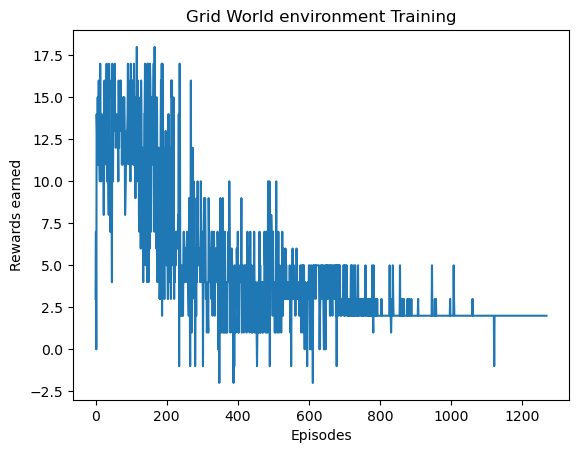

In [116]:
plt.plot(cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World environment Training')

In [118]:
env = GridEnv_Deterministic()
state_size = 2
action_size = 4
agent = A2CAgent(state_size,action_size)
agent.actor.load_state_dict(torch.load('GridWorld_policy_parameters.pth'))
total_rewards_test = []

for i in range(10):
    state = env.reset()
    total_rewards = 0
    done = False
    truncated = False
    for j in range(20):
        action,_ = agent.compute_action(state)
        state, reward, terminated,truncated, info,_  = env.step(action.item())
        if terminated:
            break
        total_rewards = total_rewards + reward

    total_rewards_test.append(total_rewards)

Text(0.5, 1.0, 'Grid World environment during testing')

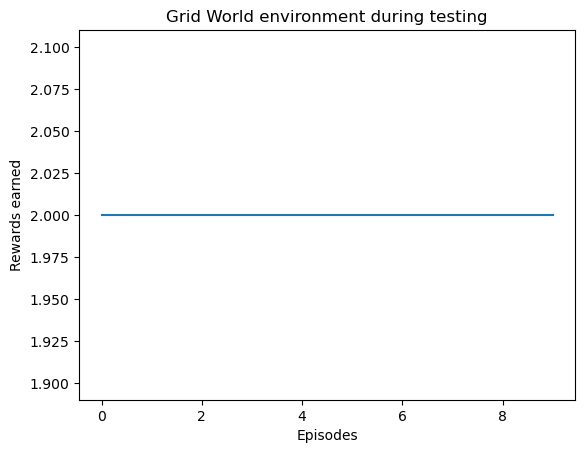

In [119]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Grid World environment during testing')

# Bipedal Walker

In [ ]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.distributions import Normal
import torch.nn.functional as F
from torch.optim import Adam
import pickle

In [46]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.mu = nn.Linear(512, action_size)
        self.sigma = nn.Linear(512, action_size)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        mu = self.mu(x)
        sigma = torch.nn.functional.softplus(self.sigma(x))
        return mu, sigma


In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Normal

class A2CAgent:
    def __init__(self, actor, critic, actor_optimizer, critic_optimizer, gamma=0.99):
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = actor_optimizer
        self.critic_optimizer = critic_optimizer
        self.gamma = gamma

    def compute_action(self, state):
        mu, sigma = self.actor(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(axis=-1)
        return action, log_prob

    def learn(self, states, actions, rewards, next_states, dones):
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_vals = self.critic(states)
        next_vals = self.critic(next_states).detach()

        TD_targets = rewards + self.gamma * next_vals * (1 - dones)

        advantages = TD_targets - current_vals
        critic_loss = F.mse_loss(current_vals, TD_targets)
        mu, sigma = self.actor(states)
        dist = Normal(mu, sigma)
        log_probs = dist.log_prob(actions).sum(dim=-1)

        actor_loss = -(log_probs * advantages.detach()).mean()

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        self.actor_optimizer.step()
        self.critic_optimizer.step()

    def save_weights(self):
        torch.save(self.actor.state_dict(), '/content/bipedal_policy_parameters_heavy.pth')


In [ ]:

class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.fc3(x)

In [ ]:
state_size = 24
action_size = 4

actor = Actor(state_size, action_size)
critic = Critic(state_size)
test_input = torch.randn(1, state_size)
mu, sigma = actor(test_input)
actor_optimizer = Adam(actor.parameters(), lr=0.001)
critic_optimizer = Adam(critic.parameters(), lr=0.001)
agent = A2CAgent(actor, critic, actor_optimizer, critic_optimizer)

In [ ]:
env = gym.make('BipedalWalker-v3')
num_episodes = 2000
cumulative_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action, log_prob = agent.compute_action(state_tensor)
        action = action[0].detach().numpy()
        k = env.step(action)
        next_state, reward, done = k[0], k[1], k[2]
        total_reward += reward
        reward_tensor = torch.tensor([reward], dtype=torch.float)
        agent.learn(state_tensor, action, reward_tensor, torch.FloatTensor([next_state]).unsqueeze(0), log_prob)
        state = next_state
        if done:
            state = env.reset()
    cumulative_rewards.append(total_reward)
    agent.save_weights()

    print(f"Episode {episode}: Total Reward = {total_reward}")


<ipython-input-31-50db9c6e084b>:39: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_vals, TD_targets)


Episode 0: Total Reward = -150.78700541049488
Episode 1: Total Reward = -109.2734230663528
Episode 2: Total Reward = -106.38315575621402
Episode 3: Total Reward = -105.1581042890257
Episode 4: Total Reward = -105.41902362850806
Episode 5: Total Reward = -106.20686456861533
Episode 6: Total Reward = -103.90202666724537
Episode 7: Total Reward = -106.78149374085417
Episode 8: Total Reward = -113.7356096251725
Episode 9: Total Reward = -113.09134958699595
Episode 10: Total Reward = -107.29010402038632
Episode 11: Total Reward = -125.58500875730502
Episode 12: Total Reward = -106.76384840673457
Episode 13: Total Reward = -106.0819367058718
Episode 14: Total Reward = -108.340516961808
Episode 15: Total Reward = -107.59878514560934
Episode 16: Total Reward = -104.70840280457773
Episode 17: Total Reward = -105.85378467919615
Episode 18: Total Reward = -112.87518920175297
Episode 19: Total Reward = -104.93129583977226
Episode 20: Total Reward = -110.4090227006972
Episode 21: Total Reward = -10

Text(0.5, 1.0, 'Bipedal Walker during Training')

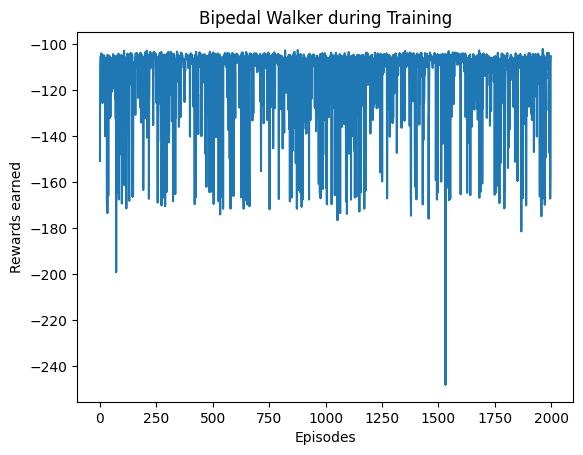

In [ ]:
plt.plot(cumulative_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Bipedal Walker during Training')

In [60]:
import gymnasium as gym
import torch

# Load the environment
env = gym.make("BipedalWalker-v3")
action_size = env.action_space.shape[0]  # Continuous action space
state_size = 4
# Initialize the agent and load the pre-trained weights
actor_eval = Actor(24, 4)  # Make sure this agent has been properly defined and matches the environment needs
actor_eval.load_state_dict(torch.load('bipedal_policy_parameters_heavy.pth'))

total_rewards_test = []

# Run the evaluation for 10 episodes
for i in range(10):
    state = env.reset()
    # print(state)

    state = torch.tensor(state[0], dtype=torch.float32)  # Convert state to tensor and add batch dimension
    # print(state.shape)
    total_reward = 0
    done = False
    truncated = False

    while not done and not truncated:
        # print(state.shape)
        state = torch.unsqueeze(torch.tensor(state), 0)
        # print(state.shape)
        action, _ = agent.compute_action(state)
        # print(type(action))
        # print(action)
        state, reward, done, truncated, info = env.step(action[0])  # Execute the action in the environment
        # print(state)
        # state = torch.tensor(state[0], dtype=torch.float32).unsqueeze(0)  # Update state and add batch dimension
        total_reward += reward

        if done or truncated:
            break

    total_rewards_test.append(total_reward)
    print(f"Episode {i+1}: Total Reward = {total_reward}")

print("Average Reward:", sum(total_rewards_test) / len(total_rewards_test))


<ipython-input-60-d888f0ded327>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.unsqueeze(torch.tensor(state), 0)
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'torch.Tensor'>
  logger.warn(


Episode 1: Total Reward = -80.8257064232727
Episode 2: Total Reward = -77.75309161178457
Episode 3: Total Reward = -83.50825948478484
Episode 4: Total Reward = -91.40513869321228
Episode 5: Total Reward = -100.4128272022537
Episode 6: Total Reward = -108.59185549775015
Episode 7: Total Reward = -90.63587657266591
Episode 8: Total Reward = -87.94341003579139
Episode 9: Total Reward = -120.72572377186205
Episode 10: Total Reward = -102.6547342394249
Average Reward: tensor(-94.4457, dtype=torch.float64)


Text(0.5, 1.0, 'Bipedal Walker during Evaluation')

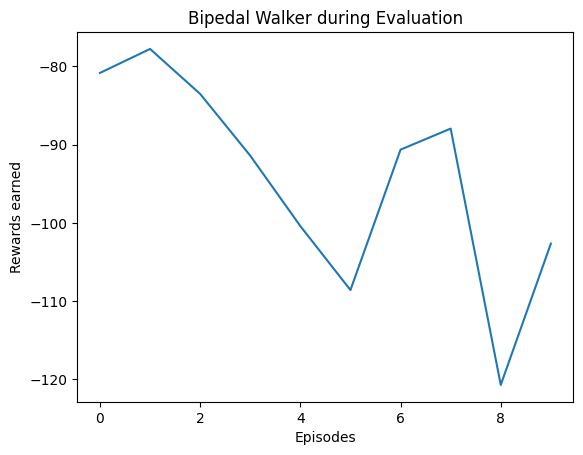

In [62]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Bipedal Walker during Evaluation')

### Bonus: Pong Atari Environment

#### Installation ATARI
pip install --upgrade git+https://github.com/openai/gym
pip install autorom

AutoRom    

pip install --upgrade gym[atari]


In [9]:
pip install ale-py

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install gym 
!pip install 'gym[box2d]'
!pip install atari_py

In [172]:
from ale_py import ALEInterface

ale = ALEInterface()

In [209]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 26 * 20,128)  # Adjust 26*20 based on the output size after convolutions
        self.fc2 = nn.Linear(128,6)  # 14 nodes for the output layer

    def forward(self, x):
        x = x.float()  # Convert uint8 to float
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 26 * 20)  # Adjust 26*20 based on the output size after convolutions
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [210]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 26 * 20,64)  # Adjust 26*20 based on the output size after convolutions
        self.fc2 = nn.Linear(64,1)  # 14 nodes for the output layer

    def forward(self, x):
        x = x.float()  # Convert uint8 to float
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 26 * 20)  # Adjust 26*20 based on the output size after convolutions
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [211]:
class A2CAgent:
    def __init__(self):
        self.actor = Actor()
        self.critic = Critic()
        lr_actor = 0.001
        lr_critic = 0.001
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = 0.99

  
    def compute_action(self,state):
        # state = torch.FloatTensor(state).unsqueeze(0)
        action_probs= self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action,dist
    
    def learn(self,state,action,reward,next_state,done,dist):
        # state = torch.FloatTensor(state)
        reward = torch.FloatTensor([reward])
        # next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor([done])
        
        log_probs = dist.log_prob(action)
        next_state_value = self.critic(next_state)
        current_state_value = self.critic(state)

        TD_target = reward + (1 - done) * self.gamma * next_state_value
        TD_target = torch.FloatTensor(TD_target)
        current_state_value = torch.FloatTensor(current_state_value)
        advantages = TD_target - current_state_value

        # Actor loss
        self.actor_optimizer.zero_grad()
        actor_loss = -torch.mean(log_probs * advantages.detach())
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic loss
        self.critic_optimizer.zero_grad()
        critic_loss = advantages.pow(2).mean()
        # critic_loss = F.smooth_l1_loss(current_state_value,TD_target)
        critic_loss.backward()
        self.critic_optimizer.step()

    def save_weights(self):
        torch.save(self.actor.state_dict(), 'Atari-Pong_policy_parameters.pth')
    

In [215]:
env = gym.make("ALE/Pong-v5")
action_size = env.action_space.n
agent = A2CAgent()
num_episodes = 2000
cumulative_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    state_tensor = torch.tensor(state[0], dtype=torch.float32)  # Convert to float32
    state_tensor = state_tensor.permute(2, 0, 1)  # Change dimensions to (channels, height, width)
    state_tensor = state_tensor.unsqueeze(0)  # Add a batch dimension at the beginning
    done = False
    truncated = False
    total_rewards = 0
    while not done or not truncated:
        action, dist = agent.compute_action(state_tensor)
        next_state, reward, done, truncated, info = env.step(action.item())
        next_state = torch.tensor(next_state, dtype=torch.float32) 
        next_state = next_state.permute(2, 0, 1) 
        next_state = next_state.unsqueeze(0) 
        agent.learn(state_tensor, action, reward, next_state, done, dist)
        state_tensor = next_state
        total_rewards += reward
        if done or truncated:
            break
    cumulative_rewards.append(total_rewards)
    if np.mean(cumulative_rewards[-15:])>=18:
        agent.save_weights()
        break

    print("Episode:", episode + 1, "Total Reward:", total_rewards)

/Users/marianivethaantonypushparaj/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1 Total Reward: -21.0
Episode: 2 Total Reward: -21.0
Episode: 3 Total Reward: -21.0
Episode: 4 Total Reward: -21.0
Episode: 5 Total Reward: -21.0
Episode: 6 Total Reward: -21.0
Episode: 7 Total Reward: -21.0
Episode: 8 Total Reward: -21.0
Episode: 9 Total Reward: -21.0
Episode: 10 Total Reward: -21.0
Episode: 11 Total Reward: -21.0
Episode: 12 Total Reward: -21.0
Episode: 13 Total Reward: -21.0
Episode: 14 Total Reward: -21.0
Episode: 15 Total Reward: -21.0
Episode: 16 Total Reward: -21.0
Episode: 17 Total Reward: -21.0
Episode: 18 Total Reward: -21.0
Episode: 19 Total Reward: -21.0
Episode: 20 Total Reward: -21.0
Episode: 21 Total Reward: -21.0
Episode: 22 Total Reward: -21.0
Episode: 23 Total Reward: -21.0
Episode: 24 Total Reward: -21.0
Episode: 25 Total Reward: -21.0
Episode: 26 Total Reward: -21.0
Episode: 27 Total Reward: -21.0
Episode: 28 Total Reward: -21.0
Episode: 29 Total Reward: -21.0
Episode: 30 Total Reward: -21.0
Episode: 31 Total Reward: -21.0
Episode: 32 Total

KeyboardInterrupt: 

In [216]:
torch.save(agent.actor.state_dict(), 'Atari-Pong_policy_parameters.pth')

In [227]:
env = gym.make("ALE/Pong-v5")
action_size = env.action_space.n
agent = A2CAgent()
agent.actor.load_state_dict(torch.load('Atari-Pong_policy_parameters.pth'))
total_rewards_test = []

for i in range(6):
    state = env.reset()
    state_tensor = torch.tensor(state[0], dtype=torch.float32)  # Convert to float32
    state_tensor = state_tensor.permute(2, 0, 1)  # Change dimensions to (channels, height, width)
    state = state_tensor.unsqueeze(0)  # Add a batch dimension at the beginning
    total_rewards = 0
    done = False
    truncated = False
    while not done or not truncated:
        action,_ = agent.compute_action(state)
        state, reward,done,truncated, info  = env.step(action.item())
        state = torch.tensor(state, dtype=torch.float32)  # Convert to float32
        state = state_tensor.permute(2, 0, 1)  # Change dimensions to (channels, height, width)
        state = state_tensor.unsqueeze(0)  # Add a batch dimension at the beginning
        if done or truncated:
            break
        total_rewards = total_rewards + reward

    total_rewards_test.append(total_rewards)

/Users/marianivethaantonypushparaj/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Text(0.5, 1.0, 'Pong environment during testing')

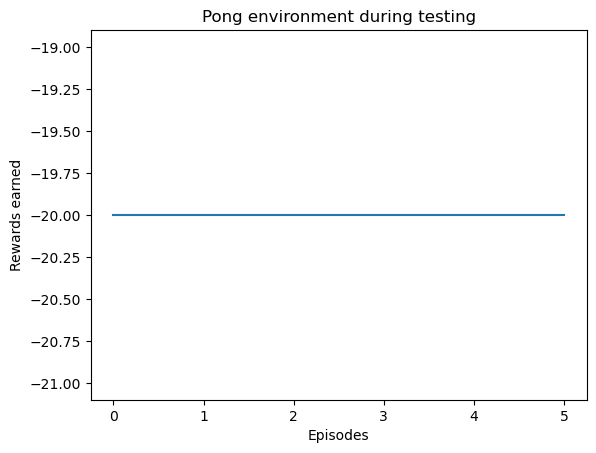

In [228]:
plt.plot(total_rewards_test)
plt.xlabel('Episodes')
plt.ylabel('Rewards earned')
plt.title('Pong environment during testing')

# References

1. Professor Alina Vereschaka's RL Handbook
2. https://huggingface.co/blog/deep-rl-a2c#advantage-actor-critic-a2c
3. https://github.com/lnpalmer/A2C/blob/master/train.py
4. https://github.com/danalytixx/Deep-Reinforcement-Learning/blob/main/Advantage%20Actor%20Critic%20algorithm%20_%20A2C%20_Pong%20OenAIGym.ipynb
5. https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/actor_critic/tensorflow2/actor_critic.py